# Figure 3: Circle plots of cloud amount vs. GOCCP for all +4K models

### Add paths to run locally or off NIRD

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check running location and adjust working directory appropriately.

In [4]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp_+4K/'   # inconsistent label compared to jupy_test
conv_dir ='convectivephase/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [5]:
os.listdir(case_dir)

['20201231_4Ksst_cesm2satcomp_wbf_1_inp_1',
 '20200817_4Ksst_cam6satcomp_wbf_1_inp_1',
 'sst_HadOIBl+4K_bc_1.9x2.5_2000climo_c180511.nc',
 '20201231_4Ksst_CESM2_satcomp_wbf_1_inp_100',
 '20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1',
 '20200817_4Ksst_cam6satcomp_wbf_1.25_inp_10',
 '20200817_4Ksst_cam61satcomp_wbf_1_inp_1',
 '20200817_4Ksst_cam61satcomp_wbf_0.5_inp_0.05',
 'sst_HadOIBl_bc_1.9x2.5_2000climo_c180511.nc',
 '20200830_152800_FLDSC4K_wbf_1_inp_1']

## Load data into metric classes

In [6]:
basemodels = SatComp_Metric(case_dir)

basemodels.add_case('20200817_4Ksst_cam6satcomp_wbf_1_inp_1', label="CAM6-Oslo")
basemodels.add_case('20201231_4Ksst_cesm2satcomp_wbf_1_inp_1', label="CAM6")
basemodels.add_case('20200817_4Ksst_cam61satcomp_wbf_1_inp_1', label="CAM6-OsloIce")

Loading GOCCP data...done.
Loading CALIOP SLFs...done
Loading CERES-EBAF fluxes...done.
Trying to load concatenated file for 20200817_4Ksst_cam6satcomp_wbf_1_inp_1
20200817_4Ksst_cam6satcomp_wbf_1_inp_1 load successfully.
Trying to load concatenated file for 20201231_4Ksst_cesm2satcomp_wbf_1_inp_1
20201231_4Ksst_cesm2satcomp_wbf_1_inp_1 load successfully.
Trying to load concatenated file for 20200817_4Ksst_cam61satcomp_wbf_1_inp_1
20200817_4Ksst_cam61satcomp_wbf_1_inp_1 load successfully.


In [7]:
fittedmodels = SatComp_Metric(case_dir)

fittedmodels.add_case("20200817_4Ksst_cam6satcomp_wbf_1.25_inp_10",label='CAM6-Oslo \n Fit 1')
# fittedmodels.add_case('20200414_205148_singleparam_cam61satcomp_wbf_1_inp_0.05',label='CAM6-OsloIce \n Fit 2')
fittedmodels.add_case('20200817_4Ksst_cam61satcomp_wbf_0.5_inp_0.05',label='CAM6-OsloIce \n Fit 2')
fittedmodels.add_case('20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1',label='CAM6-OsloIce \n Fit 3')
fittedmodels.add_case('20201231_4Ksst_CESM2_satcomp_wbf_1_inp_100',label="CAM6 \n Fit 4")

Loading GOCCP data...done.
Loading CALIOP SLFs...done
Loading CERES-EBAF fluxes...done.
Trying to load concatenated file for 20200817_4Ksst_cam6satcomp_wbf_1.25_inp_10
20200817_4Ksst_cam6satcomp_wbf_1.25_inp_10 load successfully.
Trying to load concatenated file for 20200817_4Ksst_cam61satcomp_wbf_0.5_inp_0.05
20200817_4Ksst_cam61satcomp_wbf_0.5_inp_0.05 load successfully.
Trying to load concatenated file for 20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1
20200817_4Ksst_cam61satcomp_wbf_0.2_inp_0.1 load successfully.
Trying to load concatenated file for 20201231_4Ksst_CESM2_satcomp_wbf_1_inp_100
20201231_4Ksst_CESM2_satcomp_wbf_1_inp_100 load successfully.


## Plot the stuff

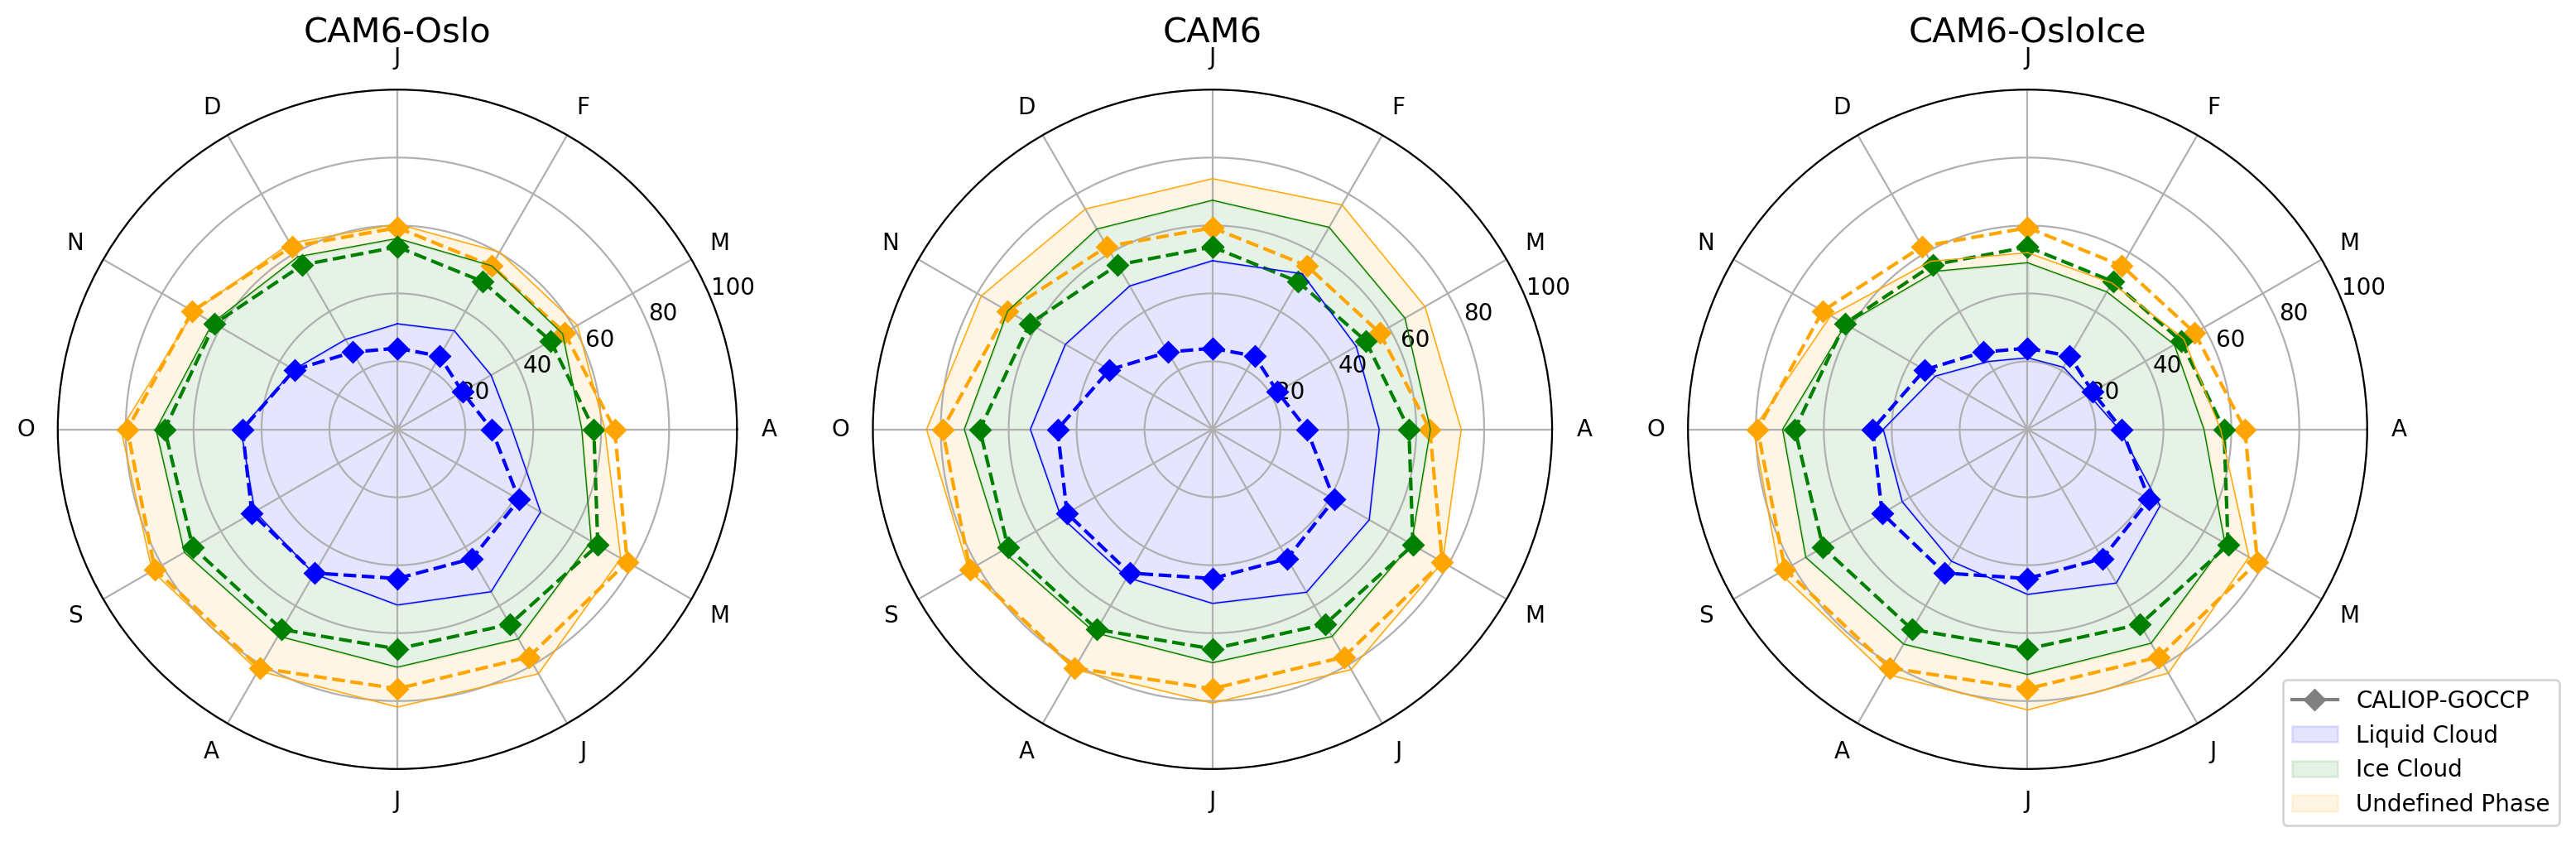

In [8]:
fig3a = basemodels.cloud_polar_plot()

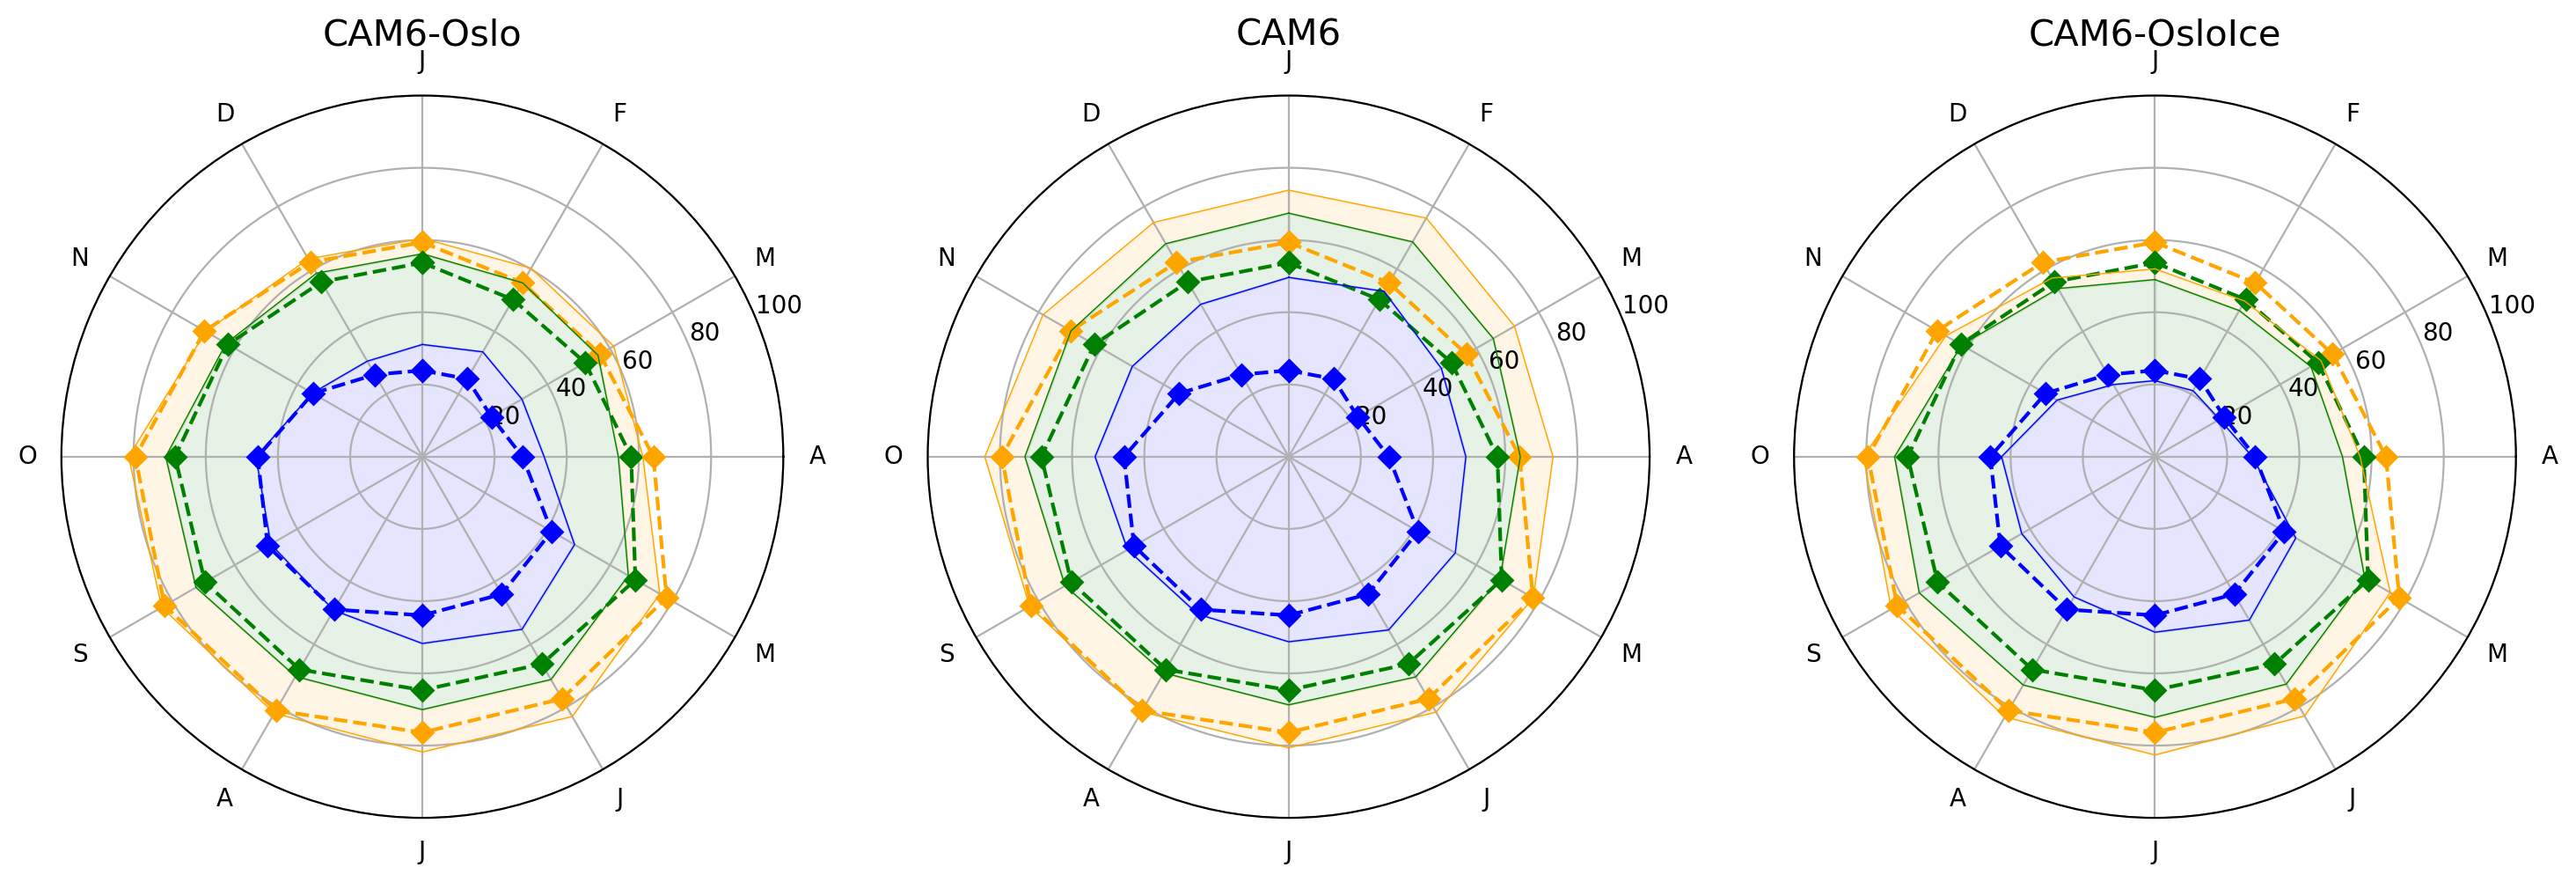

In [9]:
# Hide legend
fig3a.axes[-1].legend().set_visible(False)
fig3a

In [11]:
to_png(fig3a,"combined_4KcircleplotsA2")

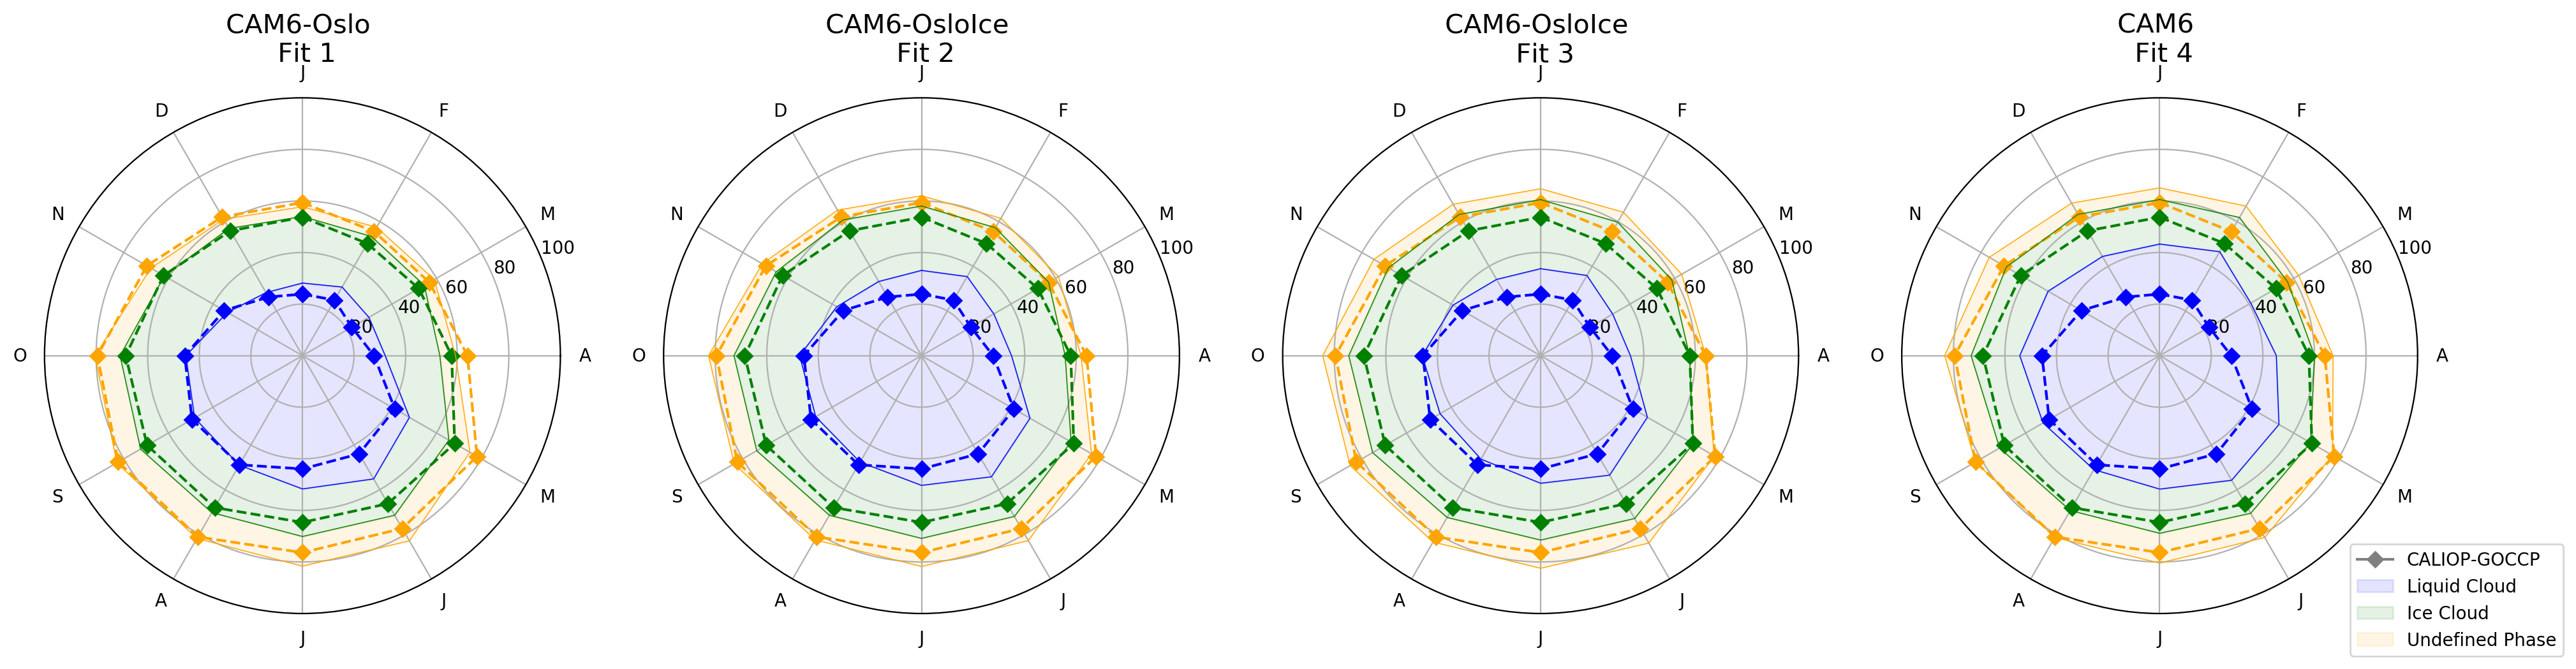

In [10]:
fig3b = fittedmodels.cloud_polar_plot()

In [12]:
to_png(fig3b,"combined_4KcircleplotsB2")